# Manga Translator

## Introduction

I love reading manga, and I can't wait for the next chapter of my favorite manga to be released. However, the newest chapters are usually in Japanese, and they are translated to English after some time. I want to read the newest chapters as soon as possible, so I decided to build a manga translator that can translate Japanese manga to English.

## Approach

I want to translate the text in the manga images from Japanese to English. I will first need to know where these speech bubbles are on the image. For this I will use `Yolov8` to detect the speech bubbles. Once I have the speech bubbles, I will use `manga-ocr` to extract the text from the speech bubbles. Finally, I will use `deep-translator` to translate the text from Japanese to English.

## Yolov8

`Yolov8` is a state-of-the-art, real-time object detection system [that I've used in the past before](https://github.com/Detopall/parking-lot-prediction). I will use `Yolov8` to detect the speech bubbles in the manga images.

## Manga-ocr

Optical character recognition for Japanese text, with the main focus being Japanese manga. This Python package is built and trained specifically for extracting text from manga images. This makes it perfect for extracting text from the speech bubbles in the manga images.

## Deep-translator

`Deep-translator` is a Python package that uses the Google Translate API to translate text from one language to another. I will use `deep-translator` to translate the text extracted from the manga images from Japanese to English.

## Data Preparation

This [dataset](https://universe.roboflow.com/speechbubbledetection-y9yz3/bubble-detection-gbjon/dataset/2#) contains over 8500 images of manga pages together with their annotations from Roboflow. I will use this dataset to train `Yolov8` to detect the speech bubbles in the manga images. To use this dataset with Yolov8, I will need to convert the annotations to the YOLO format, which is a text file containing the class label and the bounding box coordinates of the object in the image.

This dataset is over 1.7GB in size, so I will need to download it to my local machine. The rest of the code should be run after the dataset has been downloaded and extracted in this directory.

The dataset contains mostly English manga, but that is fine since I am only interested in the speech bubbles.

### Yolov8 format

```
class_index x1, y1, x2, y2, x3, y3, x4, y4
```

Where:
- `class_index` is the index of the class in the class list
- `(x1, y1), (x2, y2), (x3, y3), (x4, y4)` are the coordinates of the bounding box
- The coordinates are normalized to the range [0, 1]
- The coordinates are in the format `(x, y)`, where `x` is the horizontal coordinate and `y` is the vertical coordinate

### Data Preprocessing

Since the dataset is taken from Roboflow, the annotations are in the Roboflow format. I don't need to do any data preprocessing for this dataset.

### Example of the images and annotations

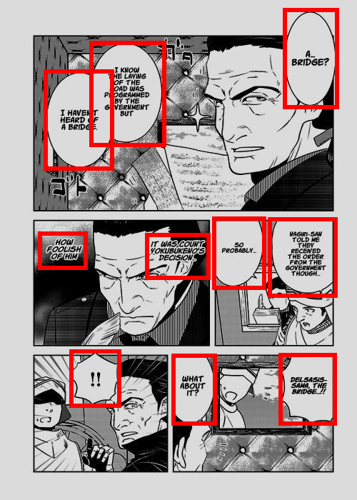

In [184]:
# Refactored code to draw OBB format bounding boxes on an image with coordinate transformation

from IPython.display import display
import random
from PIL import Image, ImageDraw
import os

# Function to draw bounding boxes on an image
def draw_bounding_boxes(image_path, label_path):
    # Load the image
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    width, height = image.size

    # Load the labels
    with open(label_path, "r") as f:
        labels = f.readlines()

    # Draw the bounding boxes
    for label in labels:
        label = label.strip().split(" ")
        class_index = label[0]
        coordinates = list(map(float, label[1:]))

        # Extract the normalized coordinates and transform them to pixel coordinates
        x1, y1 = coordinates[0] * width, coordinates[1] * height
        x2, y2 = coordinates[2] * width, coordinates[3] * height
        x3, y3 = coordinates[4] * width, coordinates[5] * height
        x4, y4 = coordinates[6] * width, coordinates[7] * height

        # Draw the polygon (bounding box)
        draw.polygon([(x1, y1), (x2, y2), (x3, y3), (x4, y4)], outline="red", width=6)

    # Resize for better display
    image.thumbnail((500, 500))
    return image

# Select a random image and corresponding label file
random_image_path = random.choice(os.listdir("data/train/images"))
random_label_path = random_image_path.replace("images", "labels").replace(".jpg", ".txt")

# Full paths
image_path = os.path.join("data/train/images", random_image_path)
label_path = os.path.join("data/train/labels", random_label_path)

# Draw and display the image with bounding boxes
image_with_boxes = draw_bounding_boxes(image_path, label_path)
display(image_with_boxes)

In [ ]:
# Fine tune the model on the dataset
from ultralytics import YOLO

model = YOLO("yolov8s.pt")

model.train(data="./data/data.yaml", epochs=5)

In [2]:
# load specific model, trained on GPU on Google Colab
import os
from ultralytics import YOLO

best_model_path = "./runs/detect/train5"

model = YOLO(os.path.join(best_model_path, "weights/best.pt"))

### Test the model


image 1/1 c:\Users\denis\Desktop\projects\data-science\manga-translator\data\test\images\-1766-_jpg.rf.3f56ca6e17c69f4022f4ff7ca271eb3c.jpg: 640x480 10 text_bubbles, 176.8ms
Speed: 2.0ms preprocess, 176.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)
Object: text_bubble
Coordinates: [389, 491, 457, 601]
Probability: 0.9195
Object: text_bubble
Coordinates: [410, 253, 472, 351]
Probability: 0.9137
Object: text_bubble
Coordinates: [257, 369, 327, 468]
Probability: 0.9119
Object: text_bubble
Coordinates: [59, 22, 120, 150]
Probability: 0.9094
Object: text_bubble
Coordinates: [45, 268, 105, 396]
Probability: 0.9079
Object: text_bubble
Coordinates: [115, 484, 187, 609]
Probability: 0.9036
Object: text_bubble
Coordinates: [52, 518, 135, 675]
Probability: 0.9005
Object: text_bubble
Coordinates: [215, 268, 280, 379]
Probability: 0.9001
Object: text_bubble
Coordinates: [138, 14, 232, 152]
Probability: 0.8822
Object: text_bubble
Coordinates: [342, 45, 428, 181]
Probability: 

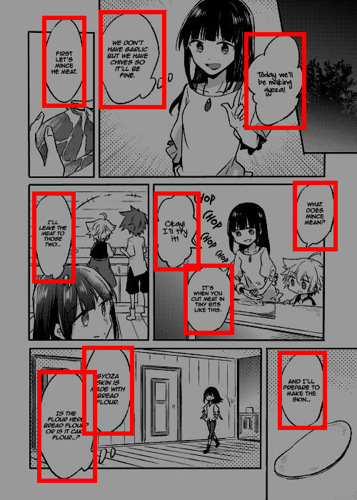

In [228]:
random_image_path = random.choice(os.listdir("data/test/images"))
image_path = f"data/test/images/{random_image_path}"
image = Image.open(image_path)

# Perform inference
result = model.predict(image_path)[0]

# Draw the bounding boxes around the text
draw = ImageDraw.Draw(image)
for box in result.boxes:
	label = result.names[box.cls[0].item()]
	coords = [round(x) for x in box.xyxy[0].tolist()]
	prob = round(box.conf[0].item(), 4)
	print("Object: {}\nCoordinates: {}\nProbability: {}".format(label, coords, prob))
	draw.rectangle(coords, outline="red", width=6)

image.thumbnail((500, 500))
display(image)

## Model Evaluations

confusion_matrix


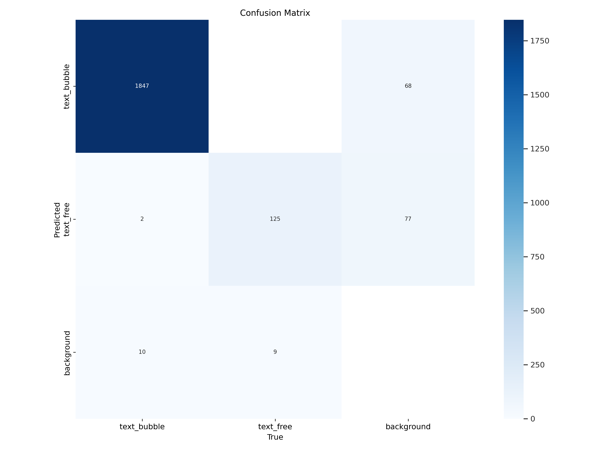

confusion_matrix_normalized


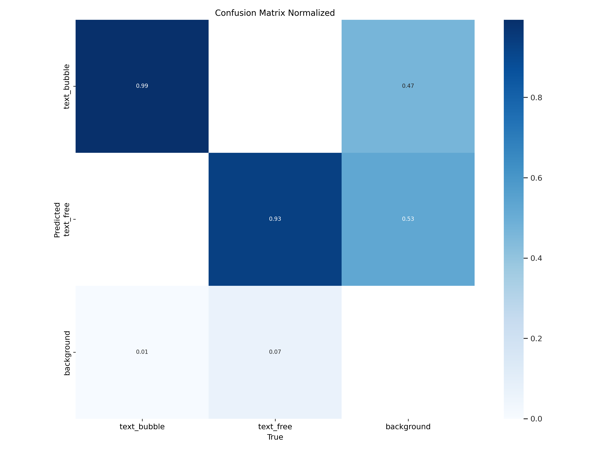

f1_curve


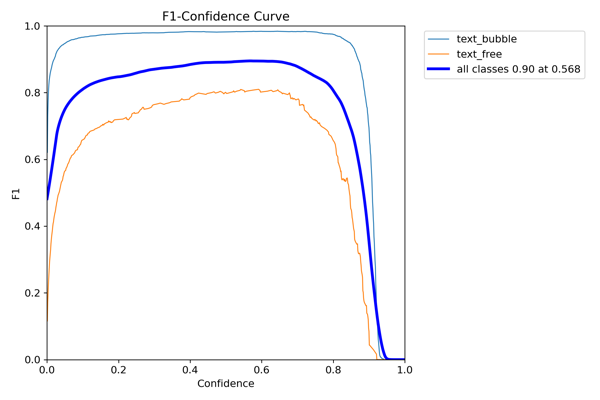

p_curve


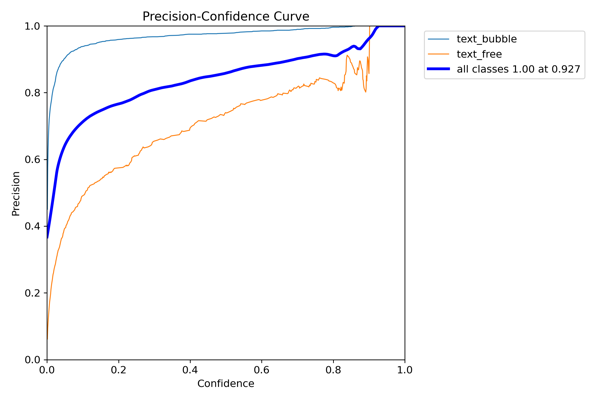

r_curve


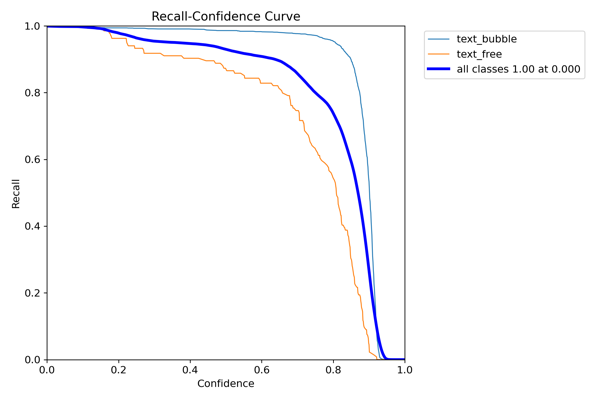

results


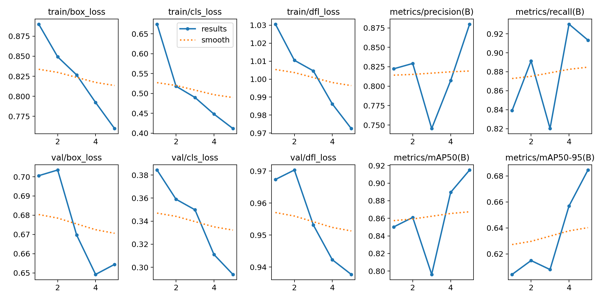

In [229]:
images_dict = {
	"confusion_matrix": f"{best_model_path}/confusion_matrix.png",
	"confusion_matrix_normalized": f"{best_model_path}/confusion_matrix_normalized.png",
	"f1_curve": f"{best_model_path}/F1_curve.png",
	"p_curve": f"{best_model_path}/P_curve.png",
	"r_curve": f"{best_model_path}/R_curve.png",
	"results": f"{best_model_path}/results.png"
}


for title, path in images_dict.items():
	image = Image.open(path)
	image.thumbnail((600, 600))
	print(title)
	display(image)

## Manga OCR

This section will contain the code for extracting text from the speech bubbles in the manga images using `manga-ocr`. But firstly we have to use the previously trained model to detect the speech bubbles in the manga images and then create individual images of the speech bubbles.

In [120]:
import uuid
from PIL import Image
import os

# Get Japanese manga image
image_path = "./011.jpg"

image = Image.open(image_path)
bounding_box_images_path = "./bounding_box_images"

# Create the directory if it doesn't exist
if not os.path.exists(bounding_box_images_path):
	os.makedirs(bounding_box_images_path)

# Clear the directory
for file in os.listdir(bounding_box_images_path):
	os.remove(os.path.join(bounding_box_images_path, file))

# Perform inference
result = model.predict(image_path)[0]

for box in result.boxes:
	label = result.names[box.cls[0].item()]
	coords = [round(x) for x in box.xyxy[0].tolist()]
	prob = round(box.conf[0].item(), 4)
	print("Object: {}\nCoordinates: {}\nProbability: {}".format(label, coords, prob))
	cropped_image = image.crop(coords)

	# save each image under a unique name
	cropped_image.save(f"{bounding_box_images_path}/{uuid.uuid4()}.png")

image 1/1 c:\Users\denis\Desktop\projects\data-science\manga-translator\011.jpg: 640x480 8 text_bubbles, 324.0ms
Speed: 14.0ms preprocess, 324.0ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 480)
Object: text_bubble
Coordinates: [608, 88, 748, 308]
Probability: 0.9075
Object: text_bubble
Coordinates: [70, 390, 250, 594]
Probability: 0.9057
Object: text_bubble
Coordinates: [86, 121, 225, 345]
Probability: 0.8989
Object: text_bubble
Coordinates: [683, 672, 827, 906]
Probability: 0.897
Object: text_bubble
Coordinates: [325, 657, 504, 917]
Probability: 0.8882
Object: text_bubble
Coordinates: [639, 389, 760, 590]
Probability: 0.8774
Object: text_bubble
Coordinates: [544, 415, 642, 599]
Probability: 0.8636
Object: text_bubble
Coordinates: [203, 94, 293, 254]
Probability: 0.8618


In [121]:
from manga_ocr import MangaOcr

mocr = MangaOcr()

text_list = []

for image_path in os.listdir(bounding_box_images_path):
	image_path = os.path.join(bounding_box_images_path, image_path)
	text = mocr(image_path)
	print("Image path:", image_path)
	print("Text:", text)
	text_list.append(text)

2024-05-27 23:39:30.251 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base


c:\Users\denis\.virtualenvs\manga-translator-P3KeupUf\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
2024-05-27 23:39:35.397 | INFO     | manga_ocr.ocr:__init__:25 - Using CPU
2024-05-27 23:39:36.400 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready


Image path: ./bounding_box_images\0670d352-f95f-426e-b9a5-0d0fb2ec8208.png
Text: 宇宙飛行士目指してるなら知ってんだろ
Image path: ./bounding_box_images\110875a7-7fa1-43b0-a045-b0abab01b8ff.png
Text: 十年前―
Image path: ./bounding_box_images\8e8f28b1-a71d-463a-93aa-17a6c5f9b6e4.png
Text: リスクもコストも跳ね上がる
Image path: ./bounding_box_images\c48e4170-03fe-4af6-ab9b-f441ad959980.png
Text: 大した見返りもないのにロケットに人を載せただけで
Image path: ./bounding_box_images\c72f7f52-8ad9-4975-a087-b0e6b21e6afd.png
Text: 日本初の有人ロケット「あさがお」の打ち上げ失敗
Image path: ./bounding_box_images\d013ad93-668d-4fe4-ad14-120fe0826e68.png
Text: 後先考えないバカのすることだ
Image path: ./bounding_box_images\dad24406-22e0-4f76-af68-2069d7e503b4.png
Text: 失敗して色んな人が苦しんだんだ
Image path: ./bounding_box_images\db24abde-523b-4400-833a-94c571541202.png
Text: 有人宇宙飛行なんて


## Deep-translator

This section will contain the code for translating the text extracted from the manga images from Japanese to English using `Deep-translator`.

In [122]:
from deep_translator import GoogleTranslator

for i, text in enumerate(text_list):
	translated_text = GoogleTranslator(source="ja", target="en").translate(text)
	print("Original text:", text)
	print("Translated text:", translated_text)
	text_list[i] = translated_text

Original text: 宇宙飛行士目指してるなら知ってんだろ
Translated text: If you're aiming to be an astronaut, you should know this.
Original text: 十年前―
Translated text: Ten years ago
Original text: リスクもコストも跳ね上がる
Translated text: Risks and costs increase
Original text: 大した見返りもないのにロケットに人を載せただけで
Translated text: Just putting people on a rocket without getting much in return.
Original text: 日本初の有人ロケット「あさがお」の打ち上げ失敗
Translated text: Launch failure of Japan's first manned rocket "Agao"
Original text: 後先考えないバカのすることだ
Translated text: That's what idiots do who don't think about the future.
Original text: 失敗して色んな人が苦しんだんだ
Translated text: I failed and many people suffered.
Original text: 有人宇宙飛行なんて
Translated text: What about manned space flight?


## Rewrite the text on the manga images

Most manga is written in a certain font style named "AntiGothi", so I will use this font style to rewrite the translated text on the manga images. This font can be downloaded from [this Github repository](https://github.com/Gutenberg-Labo/GL-NovantiquaMinamoto/blob/main/fonts/ttf/GL-NovantiquaMinamoto.ttf).

The following code is rewritten and taken from this [Github repository](https://github.com/boysugi20/python-image-translator/blob/master/main.py) to fit my needs.

In [153]:
from PIL import ImageFont, ImageDraw

def get_font(image, text, width, height):

    # Default values at start
    font_size = None  # For font size
    font = None  # For object truetype with correct font size
    box = None  # For version 8.0.0
    x = 0
    y = 0

    draw = ImageDraw.Draw(image)  # Create a draw object

    # Test for different font sizes
    for size in range(1, 500):

        # Create new font
        new_font = ImageFont.load_default(size=font_size)

        # Calculate bbox for version 8.0.0
        new_box = draw.textbbox((0, 0), text, font=new_font)

        # Calculate width and height
        new_w = new_box[2] - new_box[0]  # Bottom - Top
        new_h = new_box[3] - new_box[1]  # Right - Left

        # If too big then exit with previous values
        if new_w > width or new_h > height:
            break

        # Set new current values as current values
        font_size = size
        font = new_font
        box = new_box
        w = new_w
        h = new_h

        # Calculate position (minus margins in box)
        x = (width - w) // 2 - box[0]  # Minus left margin
        y = (height - h) // 2 - box[1]  # Minus top margin

    return font, x, y

def add_discoloration(color, strength):
	# Adjust RGB values to add discoloration
	r, g, b = color
	r = max(0, min(255, r + strength))  # Ensure RGB values are within valid range
	g = max(0, min(255, g + strength))
	b = max(0, min(255, b + strength))
	
	if r == 255 and g == 255 and b == 255:
		r, g, b = 245, 245, 245

	return (r, g, b)

def get_background_color(image, x_min, y_min, x_max, y_max):
	# Define the margin for the edges
	margin = 10

	# Crop the region around the text box
	edge_region = image.crop((x_min - margin, y_min - margin, x_max + margin, y_max + margin))

	# Find the most common color in the cropped region
	edge_colors = edge_region.getcolors(edge_region.size[0] * edge_region.size[1])
	background_color = max(edge_colors, key=lambda x: x[0])[1]

	# Add a bit of discoloration to the background color
	background_color = add_discoloration(background_color, 40)

	return background_color

def get_text_fill_color(background_color):
	# Calculate the luminance of the background color
	luminance = (
		0.299 * background_color[0]
		+ 0.587 * background_color[1]
		+ 0.114 * background_color[2]
	) / 255

	# Determine the text color based on the background luminance
	if luminance > 0.5:
		return "black"  # Use black text for light backgrounds
	else:
		return "white"  # Use white text for dark backgrounds

def translated_words_fit(translated_text, font, width, draw):
	words = translated_text.split()
	total_width = 0
	
	for word in words:
		bbox = draw.textbbox((0, 0), word, font=font)
		word_width = bbox[2] - bbox[0]
		total_width += word_width

	return total_width <= width, total_width

def recalculate_words_and_size(translated_text, font, total_width, draw, x_min, y_min, x_max, y_max):
	# Split the words into even parts
	words = translated_text.split()
	# Split evenly using total width
	even_split = total_width // len(words)
	# Split the words into lines
	lines = []
	current_line = ""
	for word in words:
		bbox = draw.textbbox((0, 0), word, font=font)
		word_width = bbox[2] - bbox[0]
		if len(current_line) + word_width > even_split:
			lines.append(current_line)
			current_line = word
		else:
			current_line += " " + word
	lines.append(current_line)
	translated_text = "\n".join(lines)
	# Calculate font size and position again
	font, x, y = get_font(image, translated_text, x_max - x_min, y_max - y_min)
	return translated_text, font, x, y


def replace_text_with_translation(image, text_boxes, translated_texts):
	draw = ImageDraw.Draw(image)

	for text_box, translated_text in zip(text_boxes, translated_texts):
		x_min, y_min, x_max, y_max = text_box

		if translated_text is None:
			continue

		# Find the most common color in the text region
		background_color = get_background_color(image, x_min, y_min, x_max, y_max)

		# Draw a rectangle to cover the text region with the original background color
		draw.rectangle(((x_min, y_min), (x_max, y_max)), fill=background_color)

		# Calculate font size and position
		font, x, y = get_font(image, translated_text, x_max - x_min, y_max - y_min)

		# Split the words if they are too long
		fits, total_width = translated_words_fit(translated_text, font, x_max - x_min, draw)
		
		if not fits or font.size < 30:
			translated_text, font, x, y = recalculate_words_and_size(translated_text, font, total_width, draw, x_min, y_min, x_max, y_max)
		
		# Use local font
		font = ImageFont.truetype(font="../fonts/mangat.ttf", size=font.size, encoding="unic")

		# Draw the translated text within the box
		draw.text(
			(x_min + x, y_min + y),
			translated_text,
			fill=get_text_fill_color(background_color),
			font=font,
		)

	return image

# Accumulate all bounding boxes and translated texts
all_boxes = []
all_translated_texts = []

for i, box in enumerate(result.boxes):
	label = result.names[box.cls[0].item()]
	coords = [round(x) for x in box.xyxy[0].tolist()]
	prob = round(box.conf[0].item(), 4)
	text = text_list[i]

	all_boxes.append(coords)
	all_translated_texts.append(text)

# Open the image
image_path = "./011.jpg"
image = Image.open(image_path)

# Draw text within all bounding boxes
image = replace_text_with_translation(image, all_boxes, all_translated_texts)

# save the image
image.save("translated_image.png")

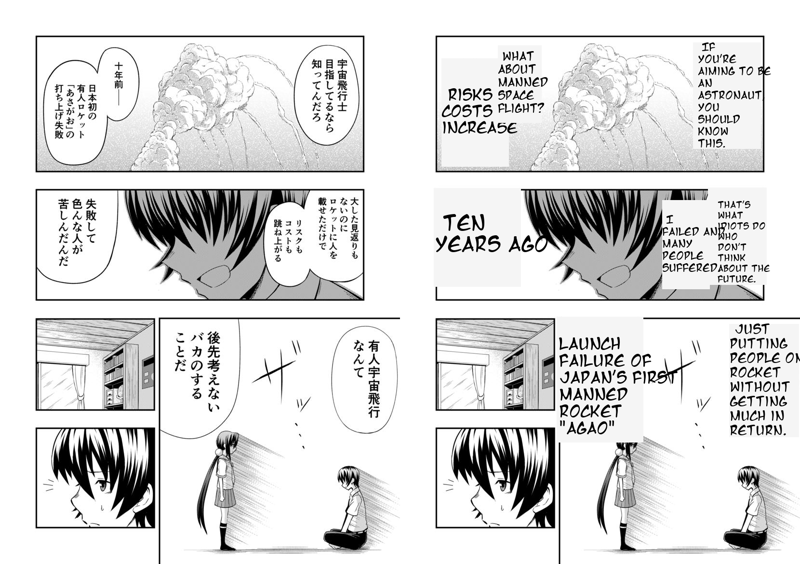

In [155]:
# A comparison of the original and modified images
image_paths = ["./011.jpg", "./translated_image.png"]

# place them next to each other
images = [Image.open(x) for x in image_paths]
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

new_image = Image.new("RGB", (total_width, max_height))

x_offset = 0
for image in images:
	new_image.paste(image, (x_offset, 0))
	x_offset += image.size[0]

new_image.thumbnail((800, 800))
display(new_image)

## All in one

This section will contain the code for the entire manga translator pipeline. This pipeline will take a manga image as input and output the translated text from the speech bubbles in the manga image and place the translated text back in the manga image.

TODO